In [2]:
import numpy as np
import pandas as pd
import os
import IPython

import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

from tqdm import tqdm

from torchvision.io import read_video
import scipy.io
import skvideo.io


In [3]:
train_images = np.load('MRI_Segmentation/train_images.npy')
train_segmentations = np.load('MRI_Segmentation/train_segmentations.npy')
test_images = np.load('MRI_Segmentation/test_images.npy')
test_segmentations = np.load('MRI_Segmentation/test_segmentations.npy')

In [5]:
class MRI_Segmentation_Dataset(Dataset):
    def __init__(self, train=True):
        if train:
            self.images = torch.from_numpy(train_images).float()
            self.segmentations = torch.from_numpy(train_segmentations).float()
        else:
            self.images = torch.from_numpy(test_images).float()
            self.segmentations = torch.from_numpy(test_segmentations).float()

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, idx):
        image = self.images[idx][None]
        segmentation = self.segmentations[idx]
        return image, segmentation

In [6]:
train_dataset = MRI_Segmentation_Dataset(train=True)
test_dataset = MRI_Segmentation_Dataset(train=False)

In [7]:
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=True)

In [8]:
def plot_segmentation(im, seg):
    im, seg = im.numpy(), seg.numpy()
    plt.imshow(im[0], cmap='gray')
    plt.imshow(np.moveaxis(seg, 0, 2), alpha=0.08)

In [9]:
class FCN(nn.Module):
    def __init__(self):
        super().__init__()
        self.down1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        ) # 84 x 84
        self.down2 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128)
        ) # 42 x 42
        self.down3 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256)
        ) # 21 x 21
        self.down4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512)
        ) # 10 x 10
        self.up1 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=0, dilation=1, output_padding=0) # 21 x 21
        self.up1_2 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256)
        )
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1) # 42 x 42
        self.up2_2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128)
        )
        self.up3 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1) # 84 x 84
        self.up3_2 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )
        self.pred = nn.Sequential(
            nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        down1 = self.down1(x)
        down2 = self.down2(down1)
        down3 = self.down3(down2)
        down4 = self.down4(down3)
        up1 = self.up1(down4)
        up1_2 = self.up1_2(torch.cat((down3, up1), dim=1))
        up2 = self.up2(up1_2)
        up2_2 = self.up2_2(torch.cat((down2, up2), dim=1))
        up3 = self.up3(up2_2)
        up3_2 = self.up3_2(torch.cat((down1, up3), dim=1))
        return self.pred(up3_2)
    

In [10]:
class AttentionFCN(nn.Module):
    def __init__(self):
        super().__init__()
        self.down1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        ) # 84 x 84
        self.down2 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128)
        ) # 42 x 42
        self.down3 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256)
        ) # 21 x 21
        self.down4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512)
        ) # 10 x 10
        self.attend1_0 = nn.Sequential(
                nn.Conv2d(256, 512, kernel_size=2, stride=2),
                nn.BatchNorm2d(512)
            )
        self.attend1_1 = nn.Sequential(
                nn.Conv2d(512, 512, kernel_size=1, stride=1),
                nn.BatchNorm2d(512)
            )
        self.attend1_2 = nn.Sequential(
                nn.Conv2d(512, 1, kernel_size=1, stride=1),
                nn.Sigmoid()
            )
        self.attend1_3 = nn.Upsample(size=(21,21), mode='bilinear', align_corners=True)
        # 21 x 21
        self.up1 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=0, dilation=1, output_padding=0) # 21 x 21
        self.up1_2 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256)
        )
        self.attend2_0 = nn.Sequential(
                nn.Conv2d(128, 256, kernel_size=1, stride=2),
                nn.BatchNorm2d(256)
            )
        self.attend2_1 = nn.Sequential(
                nn.Conv2d(256, 256, kernel_size=1, stride=1),
                nn.BatchNorm2d(256)
            )
        self.attend2_2 = nn.Sequential(
                nn.Conv2d(256, 1, kernel_size=1, stride=1),
                nn.Sigmoid()
            )
        self.attend2_3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        # 42 x 42
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1) # 42 x 42
        self.up2_2 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128)
        )
        self.attend3_0 = nn.Sequential(
                nn.Conv2d(64, 128, kernel_size=1, stride=2),
                nn.BatchNorm2d(128)
            )
        self.attend3_1 = nn.Sequential(
                nn.Conv2d(128, 128, kernel_size=1, stride=1),
                nn.BatchNorm2d(128)
            )
        self.attend3_2 = nn.Sequential(
                nn.Conv2d(128, 1, kernel_size=1, stride=1),
                nn.Sigmoid()
            )
        self.attend3_3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        # 84 x 84
        self.up3 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1) # 84 x 84
        self.up3_2 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )
        self.pred = nn.Sequential(
            nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        down1 = self.down1(x)
        down2 = self.down2(down1)
        down3 = self.down3(down2)
        down4 = self.down4(down3)
        theta1 = self.attend1_0(down3)
        phi1 = self.attend1_1(down4)
        psi1 = self.attend1_2(nn.functional.relu(theta1 + phi1))
        attn1 = self.attend1_3(psi1) * down3
        up1 = self.up1(down4)
        up1_2 = self.up1_2(torch.cat((attn1, up1), dim=1))
        theta2 = self.attend2_0(down2)
        phi2 = self.attend2_1(up1_2)
        psi2 = self.attend2_2(nn.functional.relu(theta2 + phi2))
        attn2 = self.attend2_3(psi2) * down2
        up2 = self.up2(up1_2)
        up2_2 = self.up2_2(torch.cat((attn2, up2), dim=1))
        theta3 = self.attend3_0(down1)
        phi3 = self.attend3_1(up2_2)
        psi3 = self.attend3_2(nn.functional.relu(theta3 + phi3))
        attn3 = self.attend3_3(psi3) * down1
        up3 = self.up3(up2_2)
        up3_2 = self.up3_2(torch.cat((attn3, up3), dim=1))
        return self.pred(up3_2)
    

Run ID: 23385


Epoch 1: 100%|██████████| 123/123 [00:43<00:00,  2.84batch/s]


Epoch 0 Dice Score: 0.9293784300486246


Epoch 2: 100%|██████████| 123/123 [00:43<00:00,  2.84batch/s]


Epoch 1 Dice Score: 0.9414081374804179


Epoch 3: 100%|██████████| 123/123 [00:43<00:00,  2.83batch/s]


Epoch 2 Dice Score: 0.9412454764048258


Epoch 4: 100%|██████████| 123/123 [00:43<00:00,  2.82batch/s]


Epoch 3 Dice Score: 0.9439179301261902


Epoch 5: 100%|██████████| 123/123 [00:43<00:00,  2.84batch/s]


Epoch 4 Dice Score: 0.9414177735646566


Epoch 6: 100%|██████████| 123/123 [00:43<00:00,  2.84batch/s]


Epoch 5 Dice Score: 0.9426615635553995


Epoch 7: 100%|██████████| 123/123 [00:43<00:00,  2.83batch/s]


Epoch 6 Dice Score: 0.9403879642486572


Epoch 8: 100%|██████████| 123/123 [00:43<00:00,  2.84batch/s]


Epoch 7 Dice Score: 0.9457686146100363


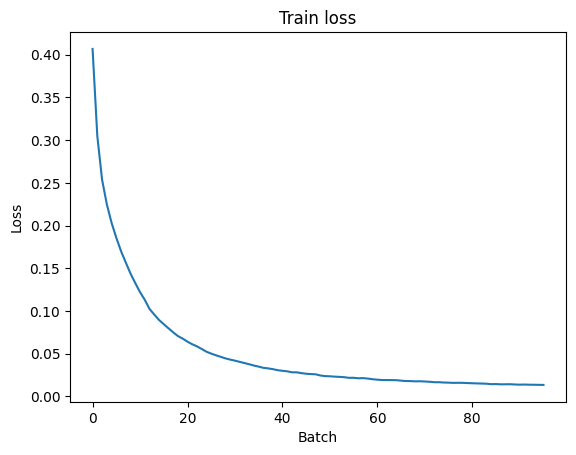

In [14]:
# Training loop
device = "cuda:3"
epochs = 8
losses = []
learning_rate = 1e-4
model = FCN().to(device)
weighting = train_segmentations.sum(axis = (0,2,3))
weighting[1] /= 2
weighting = 1-torch.FloatTensor(weighting/weighting.sum()).to(device)

run = str(np.random.randint(10000,100000))
print(f'Run ID: {run}')
final_dice = None

loss_fn = torch.nn.BCELoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for i in range(epochs):
    model.train()
    running_loss = 0
    j = 0
    with tqdm(train_dataloader, unit="batch") as tepoch:
        for input, target in tepoch:
            tepoch.set_description(f"Epoch {i + 1}")
            j += 1
            input, target = input.to(device), target.to(device)
            pred = model(input)
            loss = (loss_fn(pred, target).mean(dim=(0,2,3)) * weighting).mean()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if j % 10 == 0:
                losses.append(running_loss/10)
                running_loss = 0
        with torch.no_grad():
            model.eval()
            dices = []
            for input, target in test_dataloader:
                input, target = input.to(device), target.to(device)
                output = model(input)
                intersect = (((output > 0.5) + 0) * target).sum()
                dice = (2 * intersect + 1e-2) / (((output > 0.5) + 0).sum() + target.sum() + 1e-2)
                dices.append(dice.item())
            epoch_dice = np.mean(dices)
            final_dice = epoch_dice
            tepoch.set_postfix({'dice': epoch_dice})
            print(f'Epoch {i} Dice Score: {epoch_dice}')

torch.save(model, f'MRI_Segmentation/FCN/FCN_{run}_epochs_{epochs}_dice_{final_dice}.pth')        
    
plt.plot(losses)
plt.title('Train loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.savefig(f'MRI_Segmentation/FCN/FCN_{run}_losses.png')

In [112]:
losses

[0.4067761242389679,
 0.3045706182718277,
 0.253767204284668,
 0.22493576258420944,
 0.20323694199323655,
 0.18566349744796753,
 0.1699845775961876,
 0.15667652040719987,
 0.14368245452642442,
 0.1325470343232155,
 0.12199891358613968,
 0.11299980655312539,
 0.10229376330971718,
 0.09576369822025299,
 0.08942155465483666,
 0.08448900654911995,
 0.07963258028030396,
 0.0748840443789959,
 0.07051256224513054,
 0.06757277697324753,
 0.0640118446201086,
 0.06096705421805382,
 0.058537136390805246,
 0.055468952655792235,
 0.05221741758286953,
 0.0500455055385828,
 0.04806716106832028,
 0.04625723510980606,
 0.04444373287260532,
 0.04303598664700985,
 0.041778098046779635,
 0.040374685823917386,
 0.03899824023246765,
 0.03757458291947842,
 0.036023127287626265,
 0.034818173944950105,
 0.03337683826684952,
 0.03276264183223247,
 0.031823398731648925,
 0.030641637928783893,
 0.029917054809629917,
 0.029329876974225046,
 0.028162209689617156,
 0.028126487508416176,
 0.02719697654247284,
 0.0264

In [113]:
# Training loop
device = "cuda:3"
epochs = 8
losses2 = []
learning_rate = 1e-4
model2 = AttentionFCN().to(device)
weighting = train_segmentations.sum(axis = (0,2,3))
weighting[1] /= 2
weighting = 1-torch.FloatTensor(weighting/weighting.sum()).to(device)

run = str(np.random.randint(10000,100000))
print(f'Run ID: {run}')
final_dice = None

loss_fn = torch.nn.BCELoss(reduction='none')
optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate)

for i in range(epochs):
    model2.train()
    running_loss = 0
    j = 0
    with tqdm(train_dataloader, unit="batch") as tepoch:
        for input, target in tepoch:
            tepoch.set_description(f"Epoch {i + 1}")
            j += 1
            input, target = input.to(device), target.to(device)
            pred = model2(input)
            loss = (loss_fn(pred, target).mean(dim=(0,2,3)) * weighting).mean()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if j % 10 == 0:
                losses2.append(running_loss/10)
                running_loss = 0
        with torch.no_grad():
            model2.eval()
            dices = []
            for input, target in test_dataloader:
                input, target = input.to(device), target.to(device)
                output = model2(input)
                intersect = (((output > 0.5) + 0) * target).sum()
                dice = (2 * intersect + 1e-2) / (((output > 0.5) + 0).sum() + target.sum() + 1e-2)
                dices.append(dice.item())
            epoch_dice = np.mean(dices)
            final_dice = epoch_dice
            tepoch.set_postfix({'dice': epoch_dice})
            print(f'Epoch {i} Dice Score: {epoch_dice}')

torch.save(model2, f'MRI_Segmentation/AttentionFCN/AttentionFCN_{run}_epochs_{epochs}_dice_{final_dice}.pth')        
    
plt.plot(losses2)
plt.title('Train loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.savefig(f'MRI_Segmentation/AttentionFCN/AttentionFCN_{run}_losses.png')

Run ID: 95899


Epoch 1: 100%|██████████| 123/123 [00:49<00:00,  2.47batch/s]


Epoch 0 Dice Score: 0.9334870378176371


Epoch 2:  45%|████▍     | 55/123 [00:22<00:27,  2.46batch/s]

In [15]:
model = torch.load('MRI_Segmentation/FCN/FCN_23385_epochs_8_dice_0.9457686146100363.pth').to('cuda:3')
model2 = torch.load('MRI_Segmentation/AttentionFCN/AttentionFCN_25451_epochs_8_dice_0.948214590549469.pth').to('cuda:3')

In [15]:
device = 'cuda:3'

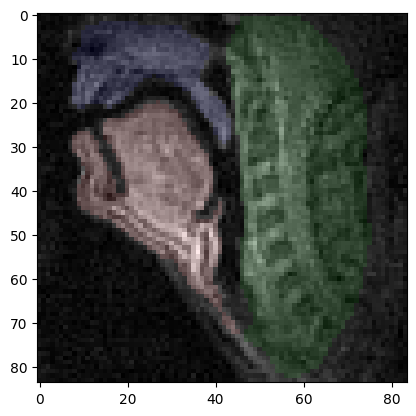

In [25]:
i = 10
inp, tar = test_dataset[i]
out = None
with torch.no_grad():
    model.eval()
    out = model(inp[None].to(device)).cpu().detach()
plot_segmentation(inp, (out[0] > 0.5) + 0.)

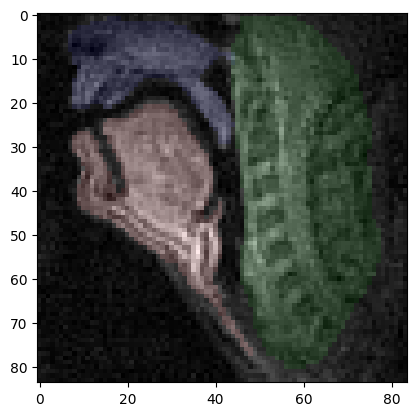

In [26]:
i = 10
inp, tar = test_dataset[i]
out = None
with torch.no_grad():
    model2.eval()
    out = model2(inp[None].to(device)).cpu().detach()
plot_segmentation(inp, (out[0] > 0.5) + 0.)

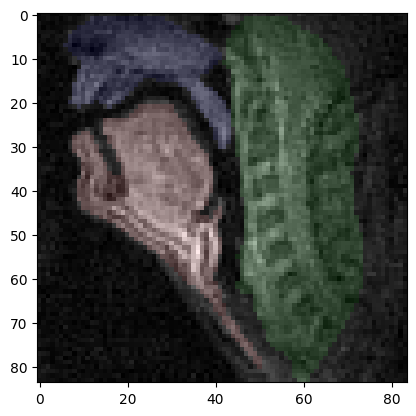

In [27]:
i = 10
inp, tar = test_dataset[i]
plot_segmentation(inp, tar)

In [ ]:
im, seg = im.numpy(), seg.numpy()
plt.imshow(im[0], cmap='gray')
plt.imshow(np.moveaxis(seg, 0, 2), alpha=0.08)

Text(0.5, 1.0, 'FCN w/ Attention')

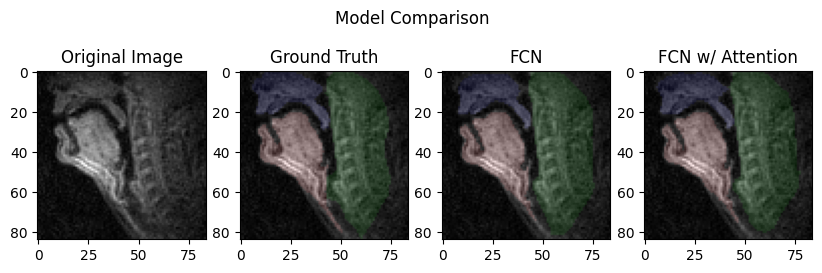

In [48]:
i = 165
inp, tar = test_dataset[i]
out1 = None
out2 = None
fig, axs = plt.subplots(1, 4, figsize=(10, 3))
fig.suptitle('Model Comparison')
with torch.no_grad():
    model.eval()
    model2.eval()
    out1 = model(inp[None].to(device)).cpu().detach().numpy()
    out2 = model2(inp[None].to(device)).cpu().detach().numpy()
inp = inp.numpy()
axs[0].imshow(inp[0], cmap='gray')
axs[0].set_title('Original Image')
axs[1].imshow(inp[0], cmap='gray')
axs[1].imshow(np.moveaxis(tar.numpy(), 0, 2), alpha=0.08)
axs[1].set_title('Ground Truth')
axs[2].imshow(inp[0], cmap='gray')
axs[2].imshow(np.moveaxis((out1[0] > 0.5) + 0., 0, 2), alpha=0.08)
axs[2].set_title('FCN')
axs[3].imshow(inp[0], cmap='gray')
axs[3].imshow(np.moveaxis((out2[0] > 0.5) + 0., 0, 2), alpha=0.08)
axs[3].set_title('FCN w/ Attention')

In [65]:
vid = skvideo.io.vread('./test_seg/avi/usc_vtsf_F_25_Napa_rt_vcv_r1s1.avi')[1400:1800]

In [52]:
out_video = model
with torch.no_grad():
    model

(3137, 84, 84)

In [69]:
vid.shape, vid[0].mean(axis=2).shape

((400, 84, 84, 3), (84, 84))

In [99]:
frames = []
for frame in range(vid.shape[0]):
    input_frame = torch.FloatTensor(vid[frame].mean(axis=2)).to(device)[None][None]/255
    pred = np.moveaxis((model2(input_frame).detach().cpu().numpy()[0] > 0.5) + 0., 0, 2)
    frames.append(vid[frame]/255 + 0.05 * pred)
frames = np.stack(frames) * 255
    

In [100]:
skvideo.io.vwrite("outputvideo.mp4", frames)

In [105]:
i = 10
inp, tar = test_dataset[i]
inp = inp[0].numpy()
tar = tar.numpy()

In [109]:
import skimage

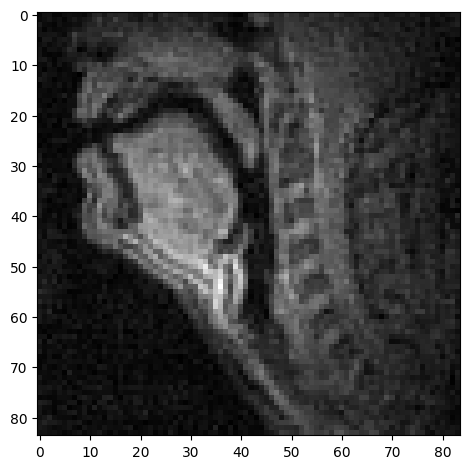

In [111]:
skimage.io.imshow(inp)